In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
train_data, train_labels = next(iter(train_loader))
valid_data, valid_labels = next(iter(valid_loader))
fixed_data, fixed_labels = next(iter(test_loader))
fixed_z = torch.randn((50, 10))
# print(train_size,'\n', train_labels,'\n', valid_labels,'\n', fixed_labels)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh, flatten=False):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и функция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
    
    def labels2onehot(self, labels):
        labels.resize_(50, 1)
        onehot_labels = torch.zeros(50, 10)
        onehot_labels.scatter_(1, labels, 1)    
        return onehot_labels
    
    def forward(self, x, labels):
#         print(x.shape)
        onehot_labels = self.labels2onehot(labels)
        if self.flatten:
            x = x.view(x.shape[0], -1)
        x = torch.cat((x, onehot_labels), 1)
#         print(x.shape)
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', 
                 **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma

        self.fce = FullyConnected([784+10, 512, 128, latent_size*2], activation_fn=nn.ReLU, flatten=True)
        self.fcd = FullyConnected([latent_size+10, 128, 512, 784], activation_fn=nn.ReLU)
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)


    def encode(self, x, labels):
        h = self.fce(x, labels)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h, labels):
        flatten = torch.tanh(self.fcd(h, labels))
        x = flatten.view(-1, 1, 28, 28)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h, labels)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [8]:
models = {'VAE10': Net(10, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, labels) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data, labels)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [10]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, labels in loader:
            output = {k: m(data, labels) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data, fixed_labels).data.numpy()
            fixed_gen = models[k].decode(fixed_z, fixed_labels).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.9365
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.2686
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.2410
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.1874
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.1843
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.1907


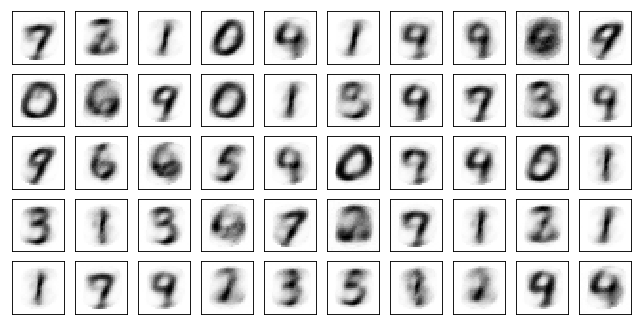

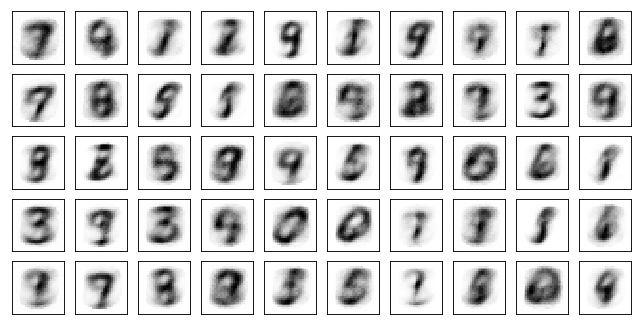

Test losses: VAE10: 0.1657/4.5917
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.1891
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.1578
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.1635
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.1697
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.1557
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.1552


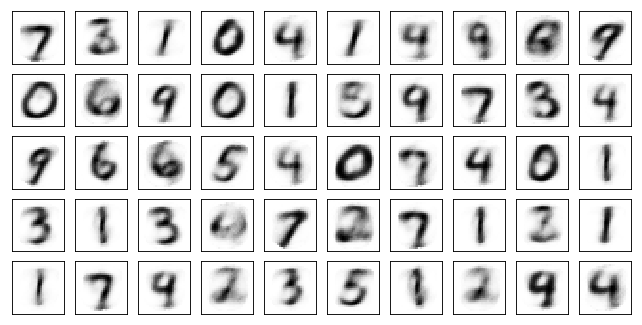

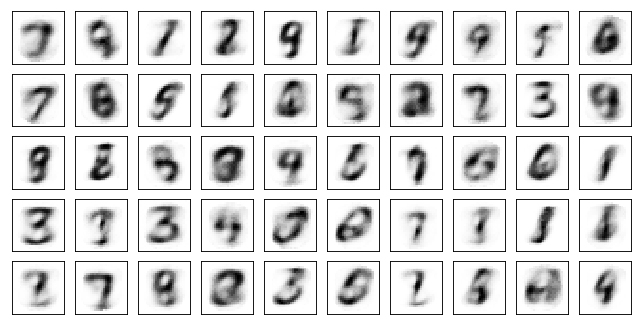

Test losses: VAE10: 0.1347/5.9407
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.1661
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.1425
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.1519
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.1518
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1356
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1336


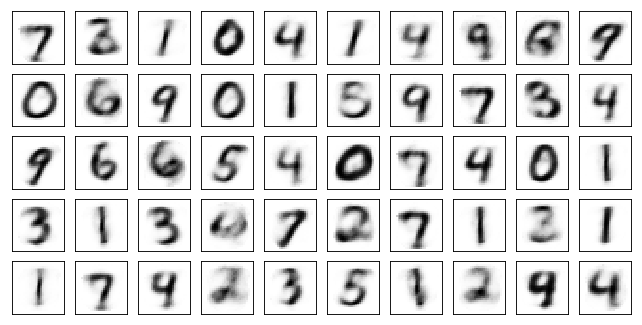

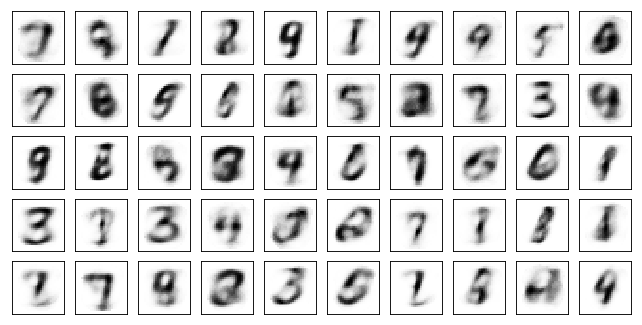

Test losses: VAE10: 0.1203/6.5626
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.1264
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1262
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1381
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.1326
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1213
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1346


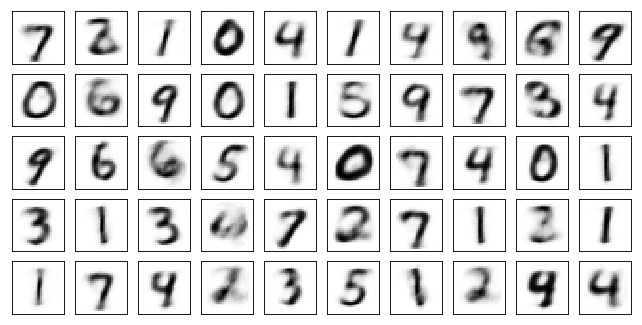

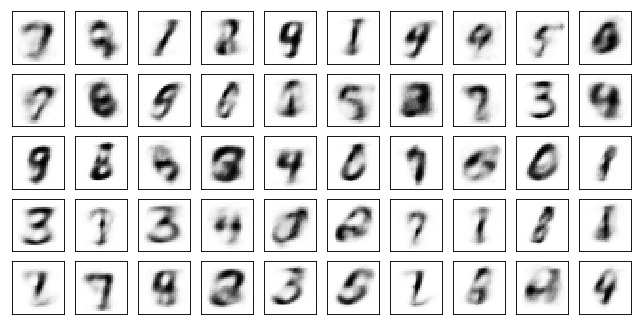

Test losses: VAE10: 0.1112/7.0074
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.1288
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1292
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1299
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1170
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1257
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1215


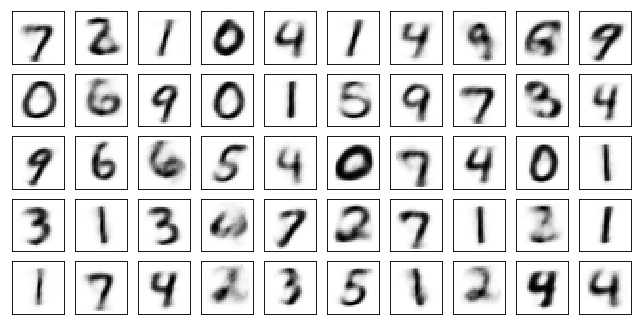

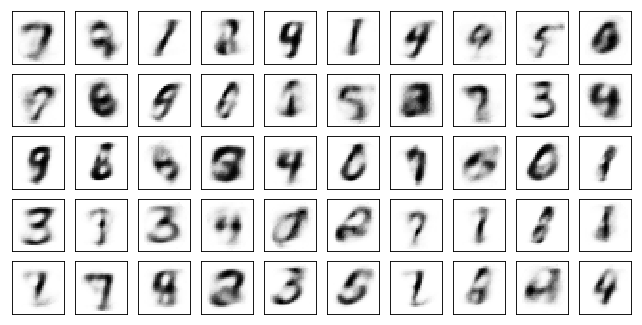

Test losses: VAE10: 0.1050/7.2150
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1104
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1240
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1123
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1204
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1158
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1098


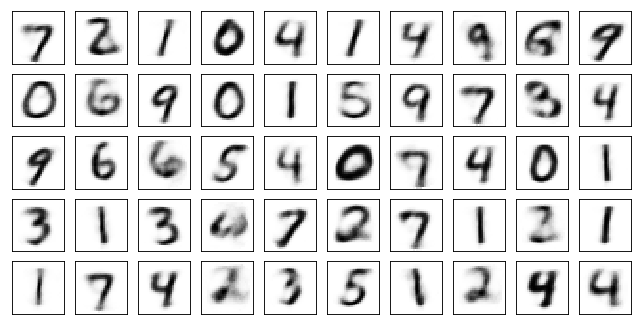

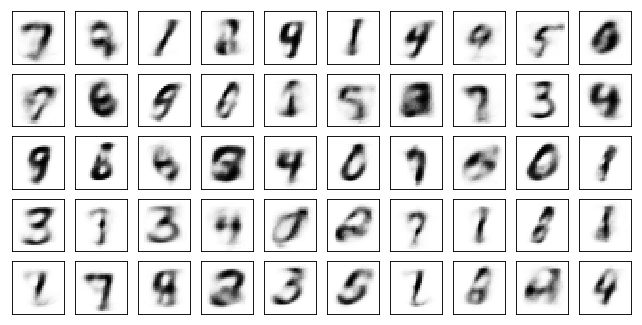

Test losses: VAE10: 0.1009/7.3911
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1256
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1154
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.1081
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1173
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1234
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1256


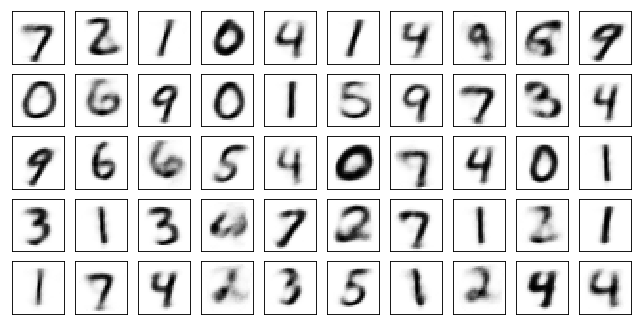

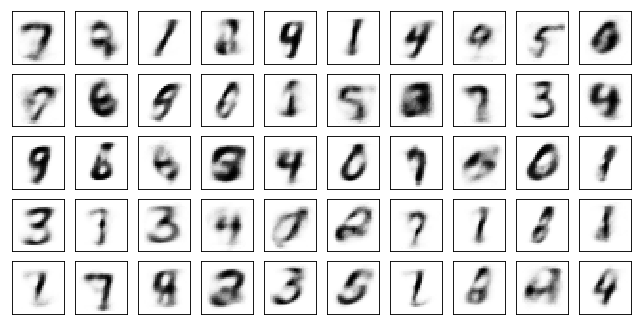

Test losses: VAE10: 0.0977/7.4190
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1237
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1004
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1202
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1101
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1164
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.1135


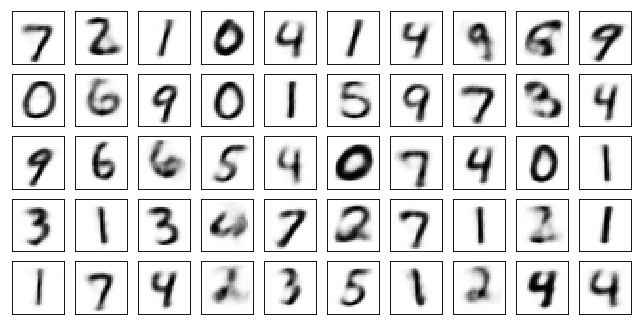

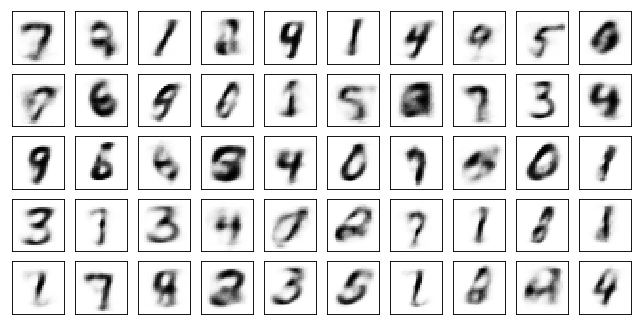

Test losses: VAE10: 0.0949/7.6257
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1147
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1194
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1207
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1082
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1261
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1083


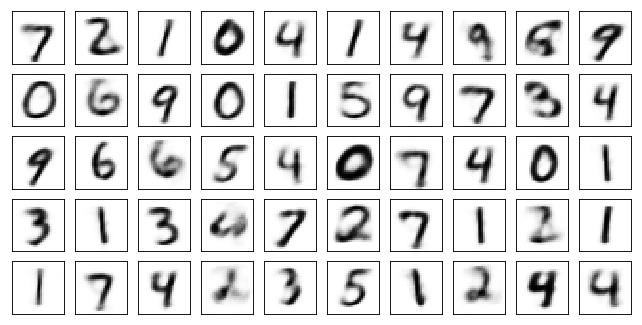

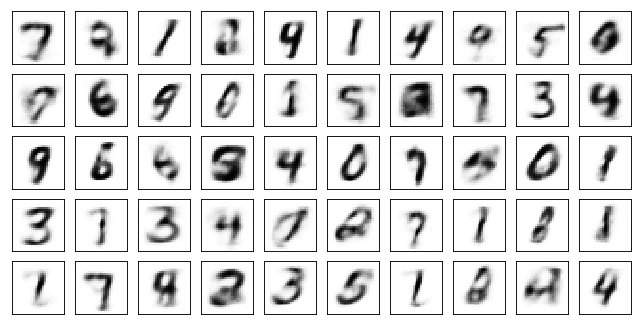

Test losses: VAE10: 0.0922/7.6978
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1069
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1164
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1060
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1128
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.1096
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1037


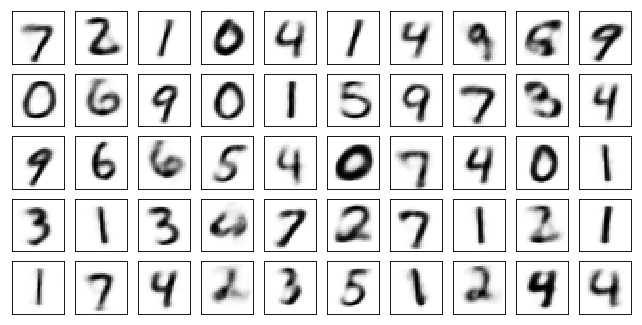

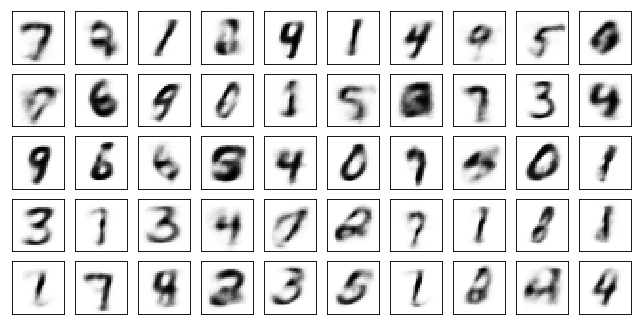

Test losses: VAE10: 0.0894/7.8807
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1142
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE10: 0.1200
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE10: 0.1182
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE10: 0.0955
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE10: 0.1019
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE10: 0.1108


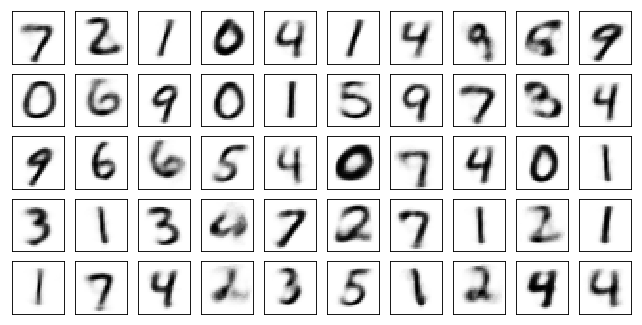

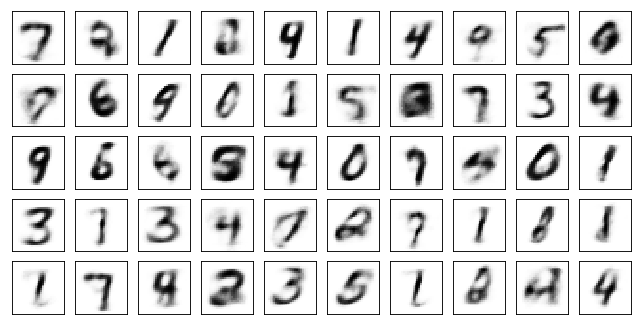

Test losses: VAE10: 0.0881/7.8334
Train Epoch: 12 [0/50000 (0%)]	Losses VAE10: 0.1055
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE10: 0.1129
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE10: 0.1180
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE10: 0.1044
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE10: 0.0944
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE10: 0.0979


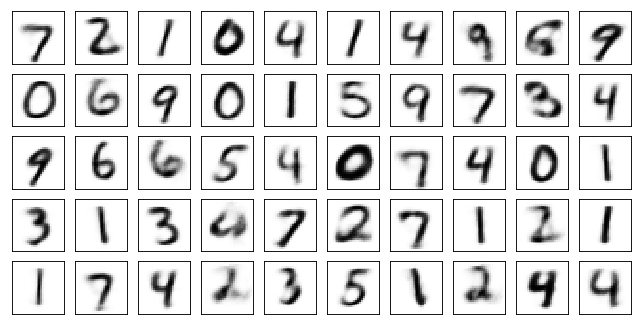

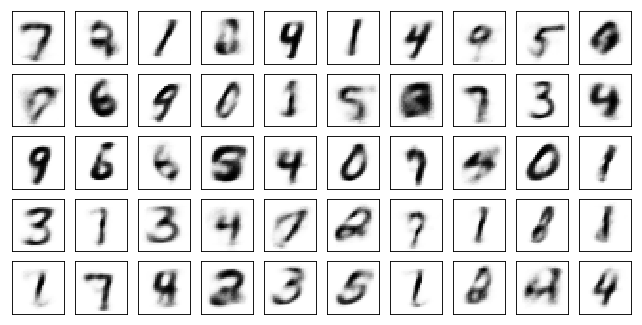

Test losses: VAE10: 0.0864/8.0865
Train Epoch: 13 [0/50000 (0%)]	Losses VAE10: 0.1104
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE10: 0.1230
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE10: 0.1108
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE10: 0.1019
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE10: 0.0970
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE10: 0.1011


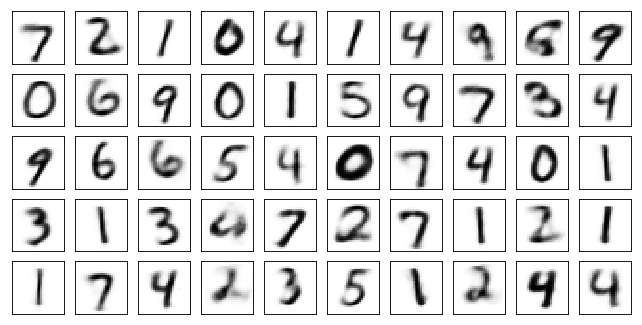

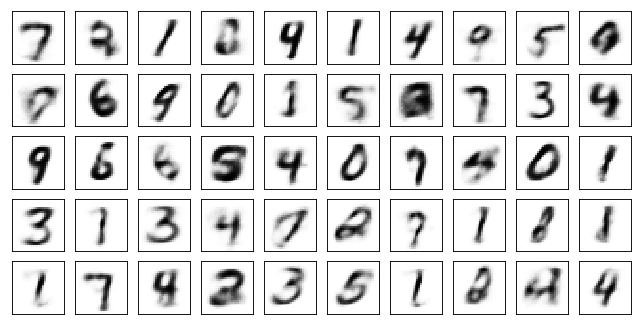

Test losses: VAE10: 0.0849/7.9313
Train Epoch: 14 [0/50000 (0%)]	Losses VAE10: 0.0995
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE10: 0.0960
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE10: 0.1032
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE10: 0.1032
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE10: 0.1095
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE10: 0.1067


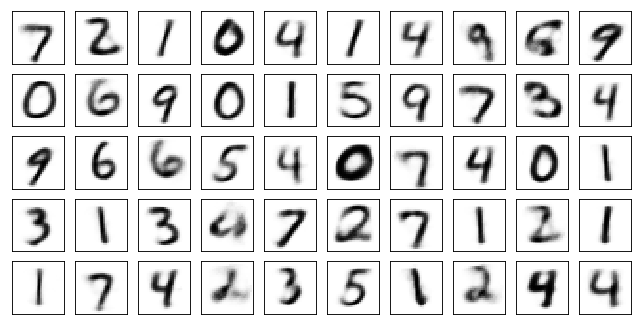

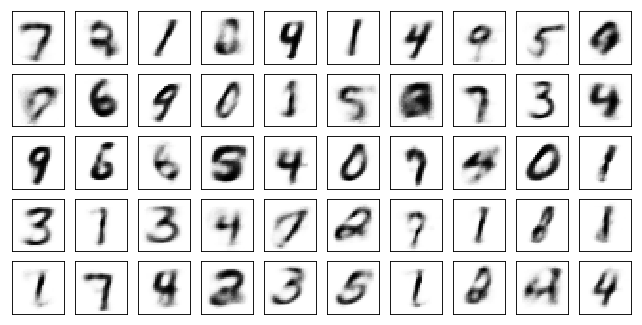

Test losses: VAE10: 0.0838/7.8825
Train Epoch: 15 [0/50000 (0%)]	Losses VAE10: 0.0998
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE10: 0.1091
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE10: 0.1049
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE10: 0.0886
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE10: 0.1098
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE10: 0.0986


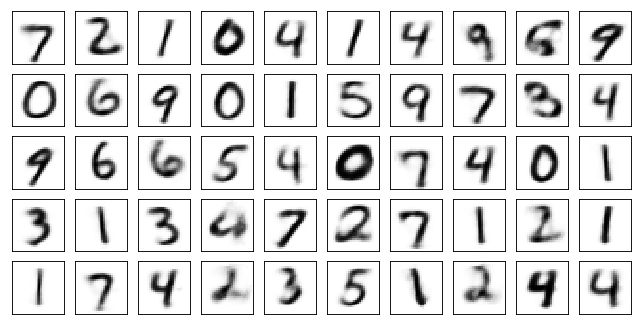

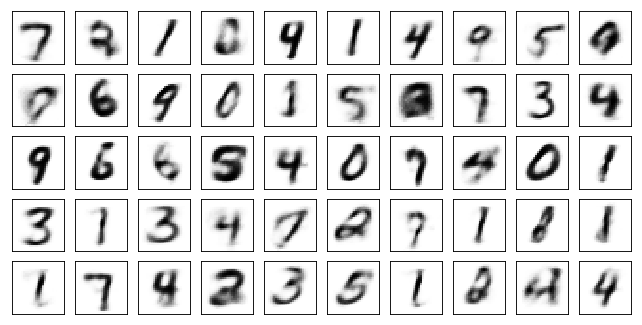

Test losses: VAE10: 0.0823/7.9458
Train Epoch: 16 [0/50000 (0%)]	Losses VAE10: 0.1069
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE10: 0.0944
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE10: 0.1077
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE10: 0.0905
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE10: 0.1029
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE10: 0.0934


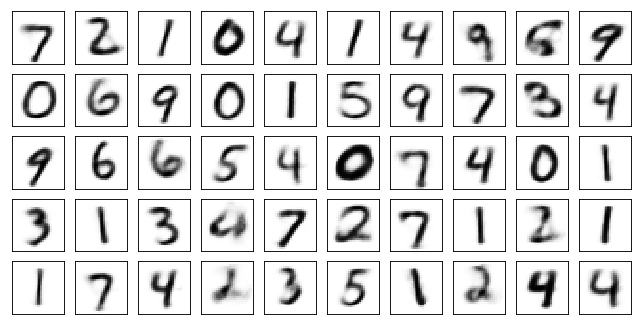

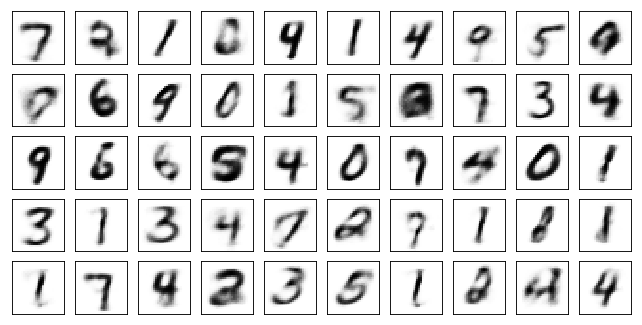

Test losses: VAE10: 0.0813/8.0177
Train Epoch: 17 [0/50000 (0%)]	Losses VAE10: 0.1060
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE10: 0.1020
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE10: 0.0987
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE10: 0.1021
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE10: 0.0987
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE10: 0.1104


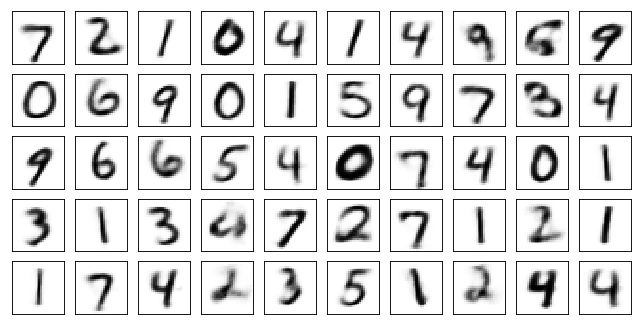

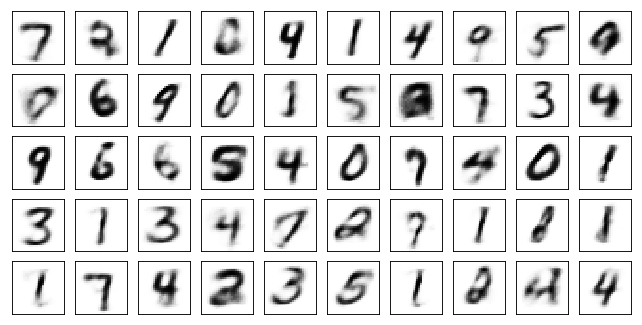

Test losses: VAE10: 0.0798/8.1725
Train Epoch: 18 [0/50000 (0%)]	Losses VAE10: 0.0971
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE10: 0.1009
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE10: 0.0908
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE10: 0.0921
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE10: 0.1038
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE10: 0.1001


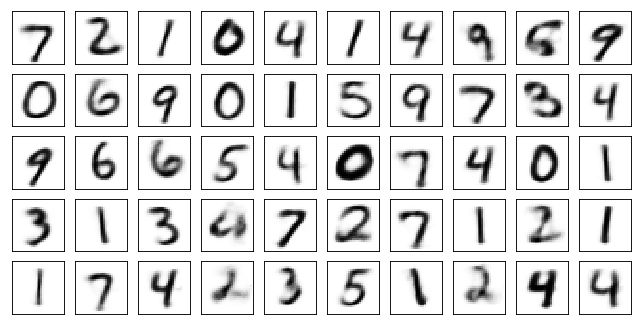

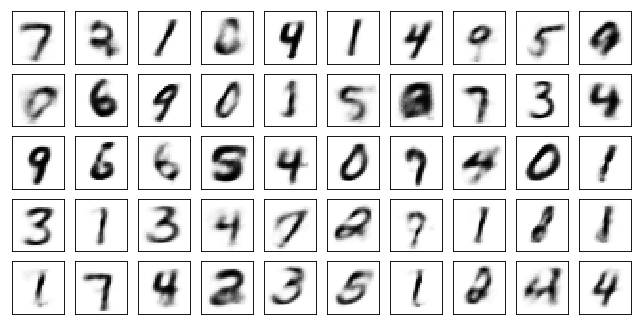

Test losses: VAE10: 0.0786/8.1735
Train Epoch: 19 [0/50000 (0%)]	Losses VAE10: 0.1060
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE10: 0.0992
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE10: 0.1017
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE10: 0.1039
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE10: 0.0939
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE10: 0.0999


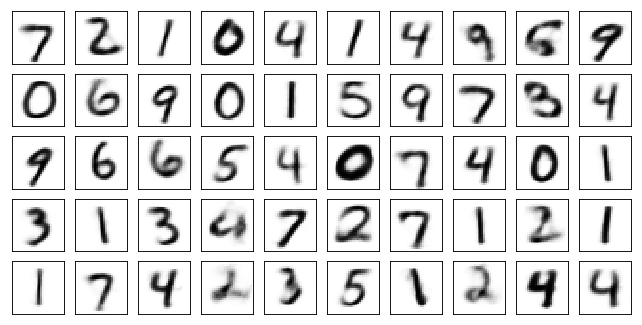

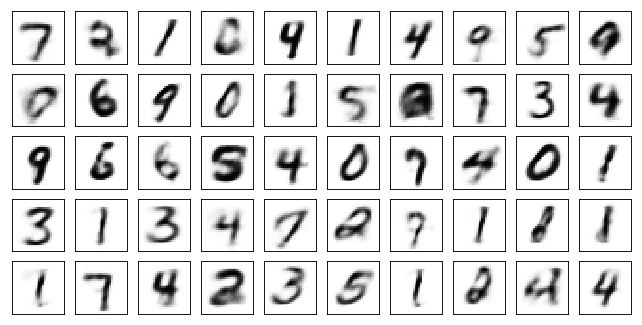

Test losses: VAE10: 0.0781/8.2868
Train Epoch: 20 [0/50000 (0%)]	Losses VAE10: 0.1011
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE10: 0.0818
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE10: 0.1071
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE10: 0.0988
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE10: 0.0856
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE10: 0.0956


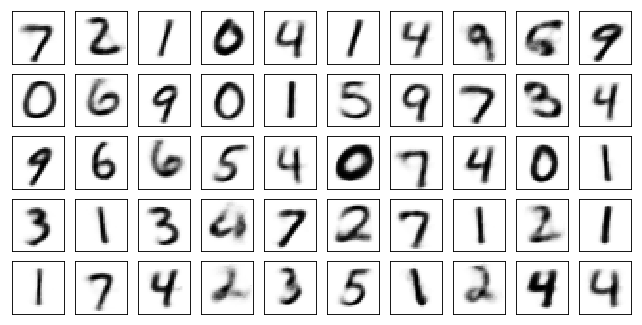

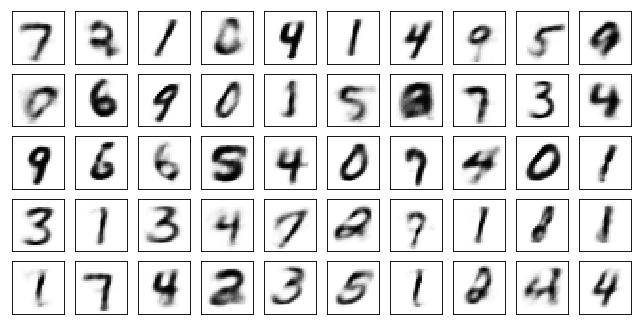

Test losses: VAE10: 0.0771/8.1508
Train Epoch: 21 [0/50000 (0%)]	Losses VAE10: 0.0931
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE10: 0.0873
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE10: 0.1061
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE10: 0.1108
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE10: 0.0953
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE10: 0.0983


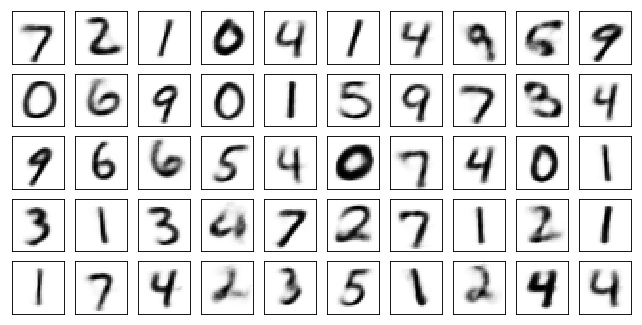

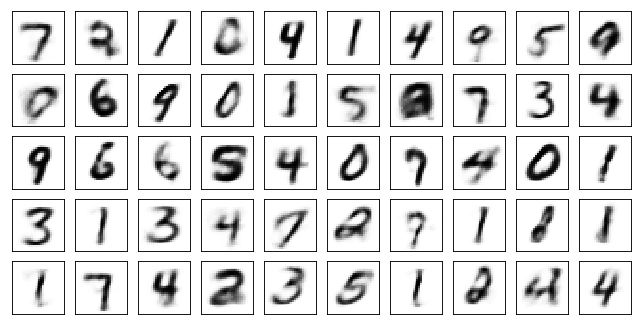

Test losses: VAE10: 0.0762/8.3102
Train Epoch: 22 [0/50000 (0%)]	Losses VAE10: 0.0969
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE10: 0.0929
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE10: 0.0913
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE10: 0.0948
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE10: 0.0840
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE10: 0.0887


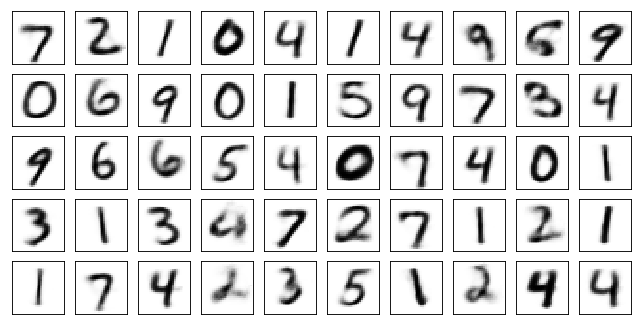

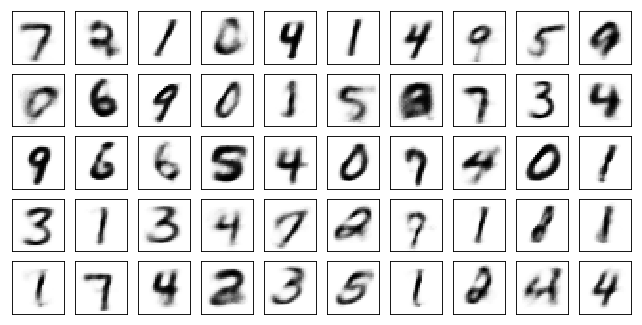

Test losses: VAE10: 0.0756/8.5234
Train Epoch: 23 [0/50000 (0%)]	Losses VAE10: 0.0938
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE10: 0.0948
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE10: 0.0894
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE10: 0.0822
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE10: 0.0891
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE10: 0.1020


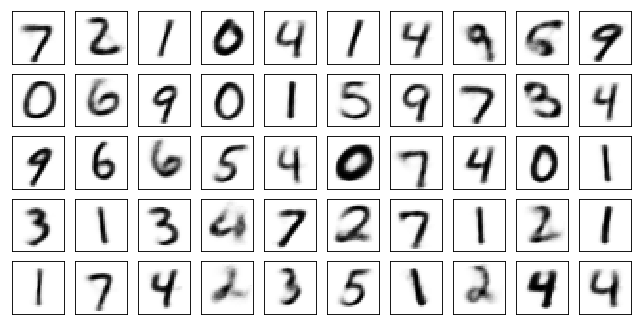

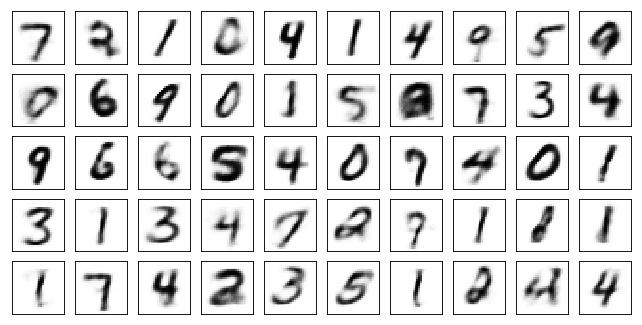

Test losses: VAE10: 0.0756/8.2688
Train Epoch: 24 [0/50000 (0%)]	Losses VAE10: 0.0963
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE10: 0.0870
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE10: 0.0924
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE10: 0.0924
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE10: 0.0918
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE10: 0.0934


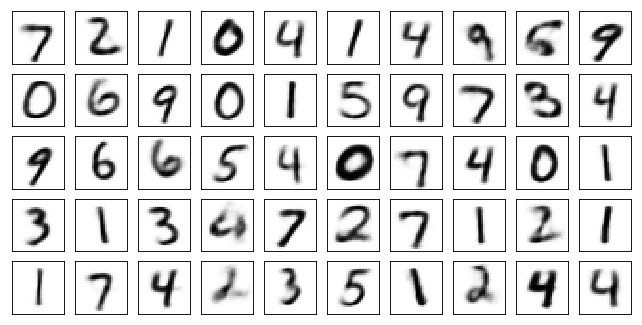

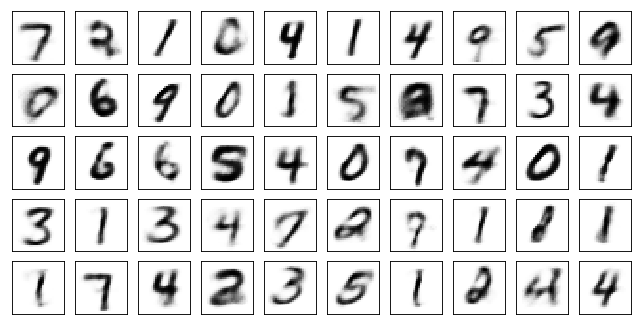

Test losses: VAE10: 0.0747/8.3605
Train Epoch: 25 [0/50000 (0%)]	Losses VAE10: 0.0939
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE10: 0.0900
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE10: 0.0790
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE10: 0.0820
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE10: 0.1006
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE10: 0.0880


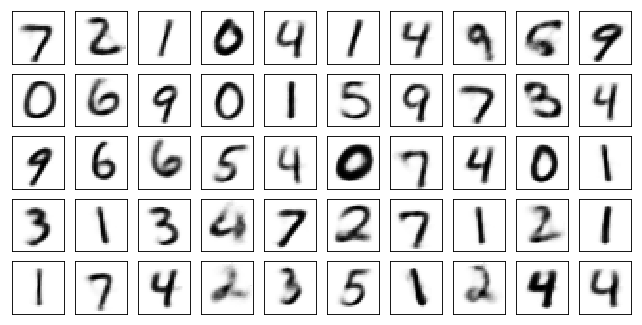

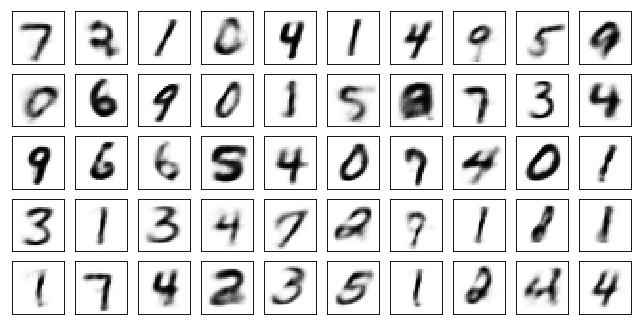

Test losses: VAE10: 0.0741/8.4089
Train Epoch: 26 [0/50000 (0%)]	Losses VAE10: 0.1024
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE10: 0.0962
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE10: 0.0986
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE10: 0.0921
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE10: 0.0876
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE10: 0.0826


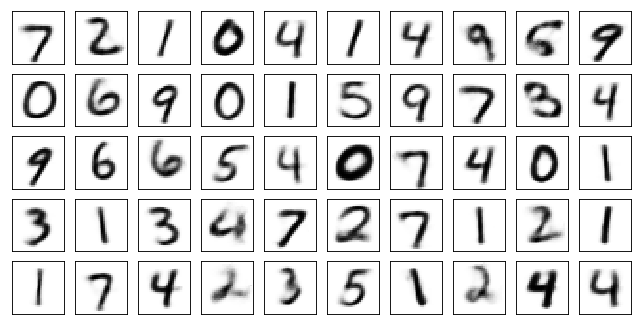

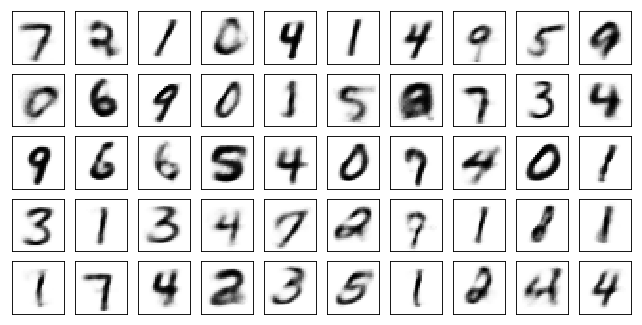

Test losses: VAE10: 0.0729/8.4690
Train Epoch: 27 [0/50000 (0%)]	Losses VAE10: 0.0900
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE10: 0.1000
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE10: 0.0944
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE10: 0.0997
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE10: 0.0948
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE10: 0.1015


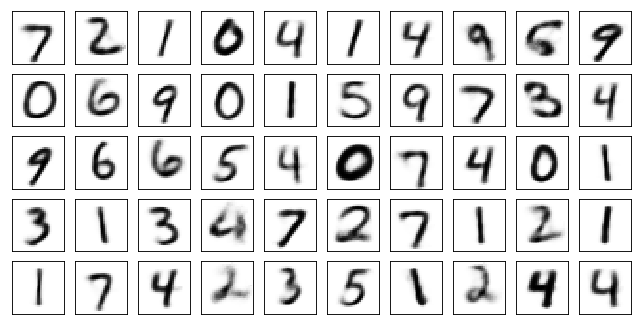

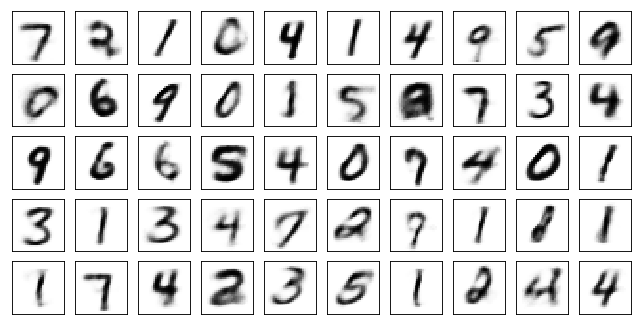

Test losses: VAE10: 0.0732/8.5215
Train Epoch: 28 [0/50000 (0%)]	Losses VAE10: 0.0932
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE10: 0.0793
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE10: 0.0939
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE10: 0.0851
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE10: 0.0854
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE10: 0.0895


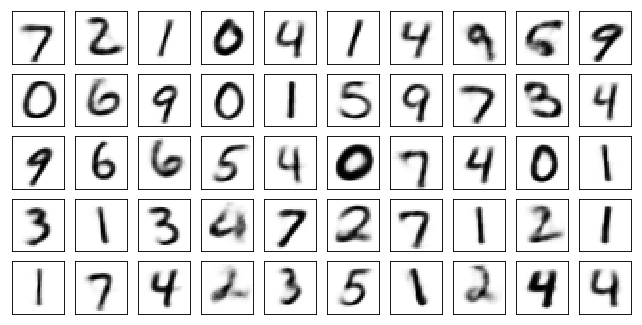

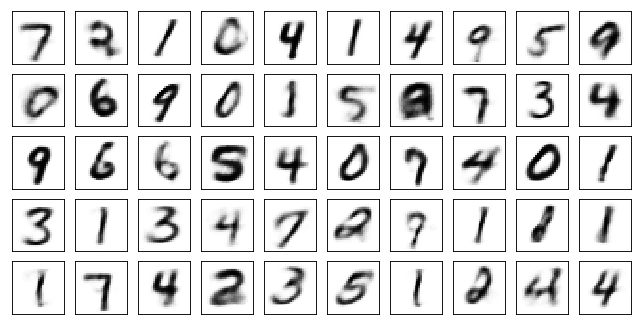

Test losses: VAE10: 0.0718/8.3997
Train Epoch: 29 [0/50000 (0%)]	Losses VAE10: 0.0888
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE10: 0.0918
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE10: 0.1018
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE10: 0.0970
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE10: 0.0949
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE10: 0.0905


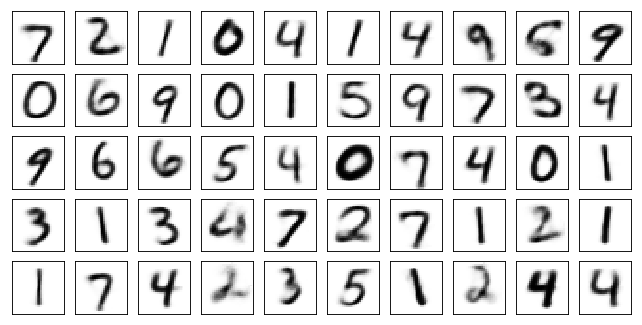

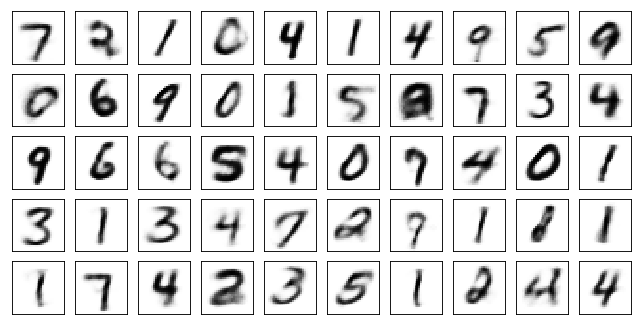

Test losses: VAE10: 0.0714/8.5202
Train Epoch: 30 [0/50000 (0%)]	Losses VAE10: 0.0910
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE10: 0.0954
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE10: 0.0983
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE10: 0.0909
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE10: 0.0910
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE10: 0.0897


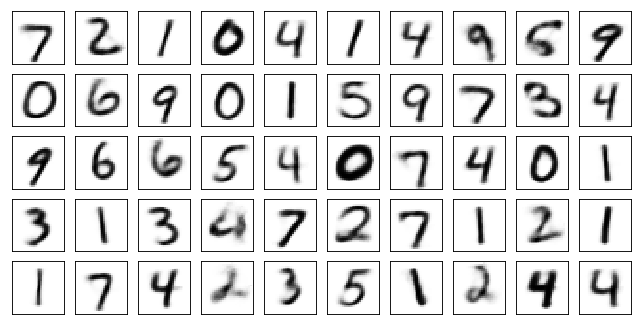

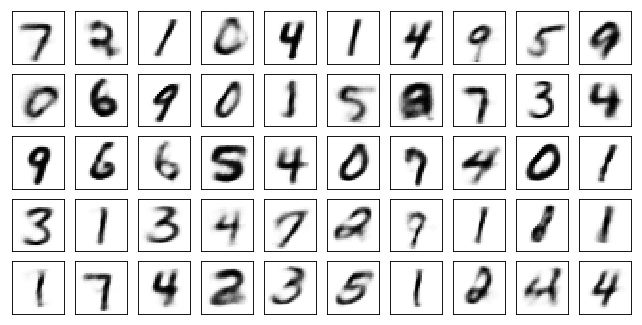

Test losses: VAE10: 0.0711/8.7529


In [11]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [12]:
# _x = torch.linspace(-3, 3, 50).reshape(50,1)
# x_ = torch.linspace(3, -3, 50).reshape(50,1)
# regular_z1 = torch.cat((_x, x_), 1)
# regular_z2 = torch.cat((_x, _x), 1)

In [13]:
# for k in models:
#     with torch.no_grad():
#         ae_data = models[k](fixed_data, fixed_labels).data.numpy()
#         fixed_gen = models[k].decode(fixed_z, fixed_labels).data.numpy()
#         regular_gen1 = models[k].decode(regular_z1, fixed_labels).data.numpy()
#         regular_gen2 = models[k].decode(regular_z2, fixed_labels).data.numpy()
#         plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
#         plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
#         plot_mnist(regular_gen1, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
#         plot_mnist(regular_gen2, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
